In [1]:
import numpy as np
import scipy.misc
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.misc import imread
from matplotlib.pyplot import imshow

In [2]:
path="imagenet-vgg-verydeep-19.mat"

In [3]:
mat_file=loadmat(path)

In [4]:
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'layers', 'meta'])

In [5]:
print(mat_file["layers"].shape)#layers key contains our main data and it is (1,43) in shape
print(mat_file["layers"][0][0].shape)#we want to see the first element of first row and firt=st column and it is (1,1) in shape
#print(mat_file["layers"][0][0][0][0])#visualizing the array
print(mat_file["layers"][0][0][0][0].shape)#accessing first element of the (1,1) array(first element by accessing first row and first column) and found that it is () shape
print(type(mat_file["layers"][0][0][0][0]))#it is of numpy.void type which means that elements it contains are of struct type means  it is the combination of string,uint8,float etc
print(mat_file["layers"][0][0][0][0][0])#accessing first element of this numpy.void type element and found that it is the name of the layer
print(mat_file["layers"][0][0][0][0][1])#accessing second element of this numpy.void type element and found that it is the name of the operation applied
#print(mat_file["layers"][0][0][0][0][2])##accessing third element of this numpy.void type element and found that it is the weight matrix
print(mat_file["layers"][0][0][0][0][2].shape)#shape of this element is (1,2) means one for the weight and other for the bias term


(1, 43)
(1, 1)
()
<class 'numpy.void'>
['conv1_1']
['conv']
(1, 2)


In [6]:
def conv_relu_layer(l_prev,layer_sequence):
    layer_weights=mat_file["layers"][0][layer_sequence][0][0][2]#it is of size (1,2)
    w=layer_weights[0][0]
    b=layer_weights[0][1]
    w=tf.constant(w)
    b=tf.constant(np.reshape(b,(b.size)))#since the shape of b is (64,1) for tensorflow bias it show be of dimensions(64,)## (b.size calculate the number of elements present in b)
    conv=tf.nn.conv2d(l_prev,filter=w,strides=[1,1,1,1],padding="SAME") + b
    relu=tf.nn.relu(conv)
    return relu

In [7]:
def pooling(layer):
    return tf.nn.avg_pool(layer,[1,2,2,1],[1,2,2,1],padding="SAME")

In [8]:
def load_model():
    vgg_model={}
    vgg_model['input']=tf.Variable(np.zeros((1,300,400,3)),dtype="float32")
    vgg_model['conv1_1']=conv_relu_layer(vgg_model['input'],0)
    vgg_model['conv1_2']=conv_relu_layer(vgg_model['conv1_1'],2)
    vgg_model['avg_pool1']=pooling(vgg_model['conv1_2'])
    vgg_model['conv2_1']=conv_relu_layer(vgg_model['avg_pool1'],5)
    vgg_model['conv2_2']=conv_relu_layer(vgg_model['conv2_1'],7)
    vgg_model['avg_pool2']=pooling(vgg_model['conv2_2'])
    vgg_model['conv3_1']=conv_relu_layer(vgg_model['avg_pool2'],10)
    vgg_model['conv3_2']=conv_relu_layer(vgg_model['conv3_1'],12)
    vgg_model['conv3_3']=conv_relu_layer(vgg_model['conv3_2'],14)
    vgg_model['conv3_4']=conv_relu_layer(vgg_model['conv3_3'],16)
    vgg_model['avg_pool3']=pooling(vgg_model['conv3_4'])
    vgg_model['conv4_1']=conv_relu_layer(vgg_model['avg_pool3'],19)
    vgg_model['conv4_2']=conv_relu_layer(vgg_model['conv4_1'],21)
    vgg_model['conv4_3']=conv_relu_layer(vgg_model['conv4_2'],23)
    vgg_model['conv4_4']=conv_relu_layer(vgg_model['conv4_3'],25)
    vgg_model['avg_pool4']=pooling(vgg_model['conv4_4'])
    vgg_model['conv5_1']=conv_relu_layer(vgg_model['avg_pool4'],28)
    vgg_model['conv5_2']=conv_relu_layer(vgg_model['conv5_1'],30)
    vgg_model['conv5_3']=conv_relu_layer(vgg_model['conv5_2'],32)
    vgg_model['conv5_4']=conv_relu_layer(vgg_model['conv5_3'],34)
    vgg_model['avg_pool5']=pooling(vgg_model['conv5_4'])
    
    return vgg_model

In [9]:
vgg_model=load_model()

In [10]:
vgg_model

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
 'avg_pool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
 'avg_pool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>,
 'avg_pool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>,
 'conv4_2': <tf.Tensor

In [11]:
#reshape and subtract the mean from each channel so as to make it compactible with VGG19 model
def reshape_normalize(image):
    image=np.reshape(image,((1,)+image.shape))
    mean=np.array([123.68, 116.779, 103.939],dtype='float32').reshape((1,1,1,3))
    image-=mean
    return image

In [12]:
def save_image(path,image):
    image=image+np.array([123.68, 116.779, 103.939],dtype='float32').reshape((1,1,1,3))
    scipy.misc.imsave(path,image)

We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$



In [13]:
#first choose the hidden layer in middle, not so deep and not so near.
#get the dimensions and then unrolling the hidden layer for both content image and generated image, then find the reduced sum 
#of square of the difference of activations of a_c and a_g.
def content_cost(a_c,a_g):
    m,n_h,n_w,n_c=a_g.get_shape().as_list()#a_c is  numpy array and a_g is a tensor and numpy have no function as get_shape
    unroll_a_c=tf.transpose(tf.reshape(a_c,[n_h*n_w,n_c]))#the reshaping is not needed in computing content cost
    unroll_a_g=tf.transpose(tf.reshape(a_g,[n_h*n_w,n_c]))#this unrolling is needed only in style cost
    c_cost=tf.reduce_sum(tf.square(tf.subtract(unroll_a_c,unroll_a_g)))/(4*n_h*n_w*n_c)
    return c_cost

### Style matrix
The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 
##### This is important to note
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. it means you have to transpose the matrix before calculating the gram matrix.

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture.

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image.

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  

In [14]:
#This style cost is defined for only one layer
def style_cost(a_s,a_g):
    m,n_h,n_w,n_c=a_g.get_shape().as_list()
    unroll_a_s=tf.transpose(tf.reshape(a_s,[n_h*n_w,n_c]))#its shape is [n_c,n_h*n_w] so that we can get the gram matrix of shape n_c,n_c
    unroll_a_g=tf.transpose(tf.reshape(a_g,[n_h*n_w,n_c]))
    gram_matrix_a_s=tf.matmul(unroll_a_s,tf.transpose(unroll_a_s))
    gram_matrix_a_g=tf.matmul(unroll_a_g,tf.transpose(unroll_a_g))
    s_cost=tf.reduce_sum(tf.square(tf.subtract(gram_matrix_a_s,gram_matrix_a_g)))/(4*((n_h*n_w*n_c)**2))
    return s_cost

### Style Weights

So far you have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers.

The numerical value given is the weightage for that particular layer

In [15]:
style_layers=[('conv1_1',0.2),('conv2_1',0.2),('conv3_1',0.2),('conv4_1',0.2),('conv5_1',0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `style_layers`.

In [16]:
def all_style_cost(model,style_layers):
    J_style=0
    for l,w in style_layers:
        act=model[l]
        a_s=sess.run(act)
        a_g=act#its a tensor, this will be computed when we run interactive session i.e. main session
        J=style_cost(a_s,a_g)
        J_style+=w*J
        return J_style

In [17]:
def total_cost(J_con,J_sty,alfa=10,beta=40):
    cost=alfa*J_con+beta* J_sty
    return cost

We'll now set up TensorFlow to optimize this with respect to $G$. To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  This allows you to run variables without constantly needing to refer to the session object, which simplifies the code.  

In [18]:
tf.reset_default_graph()
sess=tf.InteractiveSession()

In [19]:
content_image=imread('content.jpg').astype('float32')
content_image=reshape_normalize(content_image)

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [20]:
style_image=imread("style.jpg").astype('float32')
style_image=reshape_normalize(style_image)

C:\Users\Hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


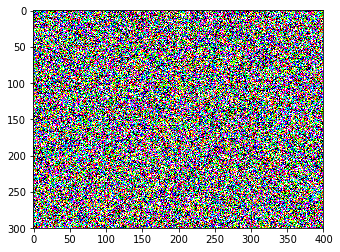

In [21]:
%matplotlib inline
noise_ratio=0.6
noise=np.random.uniform(-20,20,(1,300,400,3)).astype('float32')
generated_image=noise_ratio*noise+(1-noise_ratio)*content_image
generated_image=noise
imshow(generated_image[0])

In [28]:
model=load_model()

In [29]:
sess.run(model['input'].assign(content_image))
c_o=model['conv4_2']
a_c=sess.run(c_o)
a_g=c_o
J_content=content_cost(a_c,a_g)

In [30]:
sess.run(model['input'].assign(style_image))
J_style=all_style_cost(model,style_layers)

In [31]:
J=total_cost(J_content,J_style)

In [32]:
training=tf.train.AdamOptimizer(2.0).minimize(J)

In [33]:
def full_model(sess,gen_image,num_iter=100):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(gen_image))
    for i in range(num_iter):
        _=sess.run(training)
        generated_image=sess.run(model['input'])
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
             #save progress image
            #save_image('C:/Users/Hp/Desktop/my work'+str(i)+".png",generated_image)
    #save final image
    #save_image('generated_image.jpg',generated_image)
    return generated_image

In [34]:
full_model(sess,generated_image)

Iteration 0 :
total cost = 2.76739e+06
content cost = 15256.6
style cost = 65370.6
Iteration 20 :
total cost = 1.92535e+06
content cost = 13323.7
style cost = 44802.9
Iteration 40 :
total cost = 1.05551e+06
content cost = 13542.9
style cost = 23002.1
Iteration 60 :
total cost = 458104.0
content cost = 16428.5
style cost = 7345.49
Iteration 80 :
total cost = 277317.0
content cost = 15170.0
style cost = 3140.44


array([[[[ -70.2171402 ,    7.59987164,   48.68011093],
         [ -44.92092133,   -0.84762466,   47.99934006],
         [ -28.02323151,  -33.91605377,   53.945858  ],
         ..., 
         [  61.74430084,   25.93961334,   11.68121147],
         [  24.83952904,   20.80891037,   -1.51951432],
         [  18.76107788,   44.97562027,   41.09544754]],

        [[ -91.07225037,   12.55751133,   63.49785614],
         [ -54.03049469,  -15.80717373,   66.89714813],
         [ -61.49749756,    2.71374202,   67.01888275],
         ..., 
         [   4.93931627,   25.19931412,   71.55587006],
         [ -19.6756649 ,   19.92364311,   52.49701691],
         [  12.29049969,   29.72606659,   10.29687119]],

        [[ -34.56655502,    4.92409992,   13.41173172],
         [-123.45223236,   22.57130241,   82.50585938],
         [ -89.09553528,   12.55381584,   64.1470871 ],
         ..., 
         [  39.23864746,   33.21015549,   44.03363419],
         [  35.12854004,   19.77348709,   60.31949997],

In [238]:
writer=tf.summary.FileWriter('C:/Users/Hp/Desktop/my work')
writer.add_graph(sess.graph)